## Build Rasters from an EMO file

In [1]:
from enum import IntEnum
import pandas 
import numpy 
import timeit
import math
import matplotlib.pyplot as plt
from os import path

from typing import Tuple

import numba
from numba import jit, njit, vectorize

GEOFILE_NUMBA_SPEC = [
    ('_filePath', numba.types.unicode_type), 
    ('_west', numba.float64),
    ('_east', numba.float64),
    ('_south', numba.float64),
    ('_north', numba.float64)
]
class GeoFile(object):
    """
        File's properties.
            - filePath : path to the EMO file
            - extent : array holding the bounding box (west , east, south, north)
    """
    def __init__(self, filePath : str):
        self._filePath = filePath     
        self.west = numpy.nan
        self.east = numpy.nan
        self.south = numpy.nan
        self.north = numpy.nan
        
    @property
    def filePath(self):
        return self._filePath

    @property
    def west(self):
        return self._west
    @west.setter
    def west(self, west : numpy.float64):
        self._west = west
        
    @property
    def east(self):
        return self._east
    @east.setter
    def east(self, east : float):
        self._east = east
        
    @property
    def south(self):
        return self._south
    @south.setter
    def south(self, south : float):
        self._south = south
        
    @property
    def north(self):
        return self._north
    @north.setter
    def north(self, north : float):
        self._north = north
        
    def extent(self) -> tuple :
        return self.west, self.east, self.south, self.north
        
class EmoFile(GeoFile):
    """
        EMO file's properties.
    """
    
    ColumnDescriptions = {
        'longitude':float,'latitude':float,'minDepth':float,'maxDepth':float,'meanDepth':float,
        'standardDeviation':float,'nbOfSounds':int,'interpolatedCell':int,'smoothedDepth':float,
        'smoothedMeanDifference':float,'CDIID':str,'dtmSource':str,'other':str}
    ColumnNames = list(ColumnDescriptions.keys())
      
    def __init__(self, filePath):
        GeoFile.__init__(self, filePath)
        self.minmax = {key:[numpy.nan,numpy.nan] for (key,value) in EmoFile.ColumnDescriptions.items() if value != str}

    def min(self, columnName):
        return self.minmax[columnName][0]
    
    def max(self, columnName):
        return self.minmax[columnName][1]
    
    @property
    def minmax(self):
        return self._minmax
    @minmax.setter
    def minmax(self, minmax):
        self._minmax = minmax
        
DTMFILE_NUMBA_SPEC = [
    ('_spatialResolution', numba.float64), 
    ('_rowCount', numba.int32),
    ('_colCount', numba.int32)
]
@numba.jitclass(GEOFILE_NUMBA_SPEC + DTMFILE_NUMBA_SPEC)
class DtmFile(GeoFile):
    """
        DTM file's properties. This is a GeoFile with
           - Spatial resolution
           - Shape : a grid dimension
    """
    def __init__(self, filePath : str, spatialResolution : float, west : float, east : float, south : float, north : float) :
        self._filePath = filePath     
        self.spatialResolution = spatialResolution
        self.west, self.east = west - spatialResolution / 2.0, east + spatialResolution / 2.0
        self.south, self.north = south - spatialResolution / 2.0, north + spatialResolution / 2.0
        self.rowCount = int(round((self.north - self.south) / spatialResolution))
        self.colCount = int(round((self.east - self.west) / spatialResolution))

    @property
    def spatialResolution(self):
        return self._spatialResolution
    @spatialResolution.setter
    def spatialResolution(self, spatialResolution : float):
        self._spatialResolution = spatialResolution
      
    @property
    def rowCount(self):
        return self._rowCount
    @rowCount.setter
    def rowCount(self, rowCount : int):
        self._rowCount = rowCount
      
    @property
    def colCount(self):
        return self._colCount
    @colCount.setter
    def colCount(self, colCount : int):
        self._colCount = colCount
      
    @property
    def shape(self) -> tuple :
        return self.rowCount, self.colCount

    def row(self, latitude : float):
        """
            Compute the row index for the given latitude
            :param latitude : instance of numpy.float64
        """
        return int(math.floor((latitude - self.south) / self.spatialResolution));
    
    def column(self, longitude : float):
        """
            Compute the column index for the given longitude
            :param longitude : instance of numpy.float64
        """
        return int(math.floor((longitude - self.west) / self.spatialResolution));

    def project(self, array : numpy.array, longitudeColumn : int, latitudeColumn : int):
        """
            Compute the column and row indexes for each line of the specified array 
            :param array : array containing longitudes and latitudes
            :param longitudeColumn : index of the longitudes column in array
            :param latitudeColumn : index of the latitudes column in array
        """
        self.__project(array, longitudeColumn, self.west)
        self.__project(array, latitudeColumn, self.south)

    def __project(self, array : numpy.array, column : int, origin : float):
        for i in numba.prange(array.shape[0]):
            array[i, column] = (array[i, column] - origin) // self.spatialResolution;

class EmoDriver:
    """
        Loader of EMO file. 
        Return a EmoFile when a EMO file is parsed
    """
    
    @jit(nopython=True, parallel=True)
    def __computeMinMax(emoArray : numpy.ndarray, colIndex : int) -> Tuple[float, float] :
        result : Tuple[float, float] = [numpy.nan, numpy.nan]

        for rowIndex in numba.prange(emoArray.shape[0]):
            colValue : float = emoArray[rowIndex, colIndex]
            if not numpy.isnan(colValue) :
                result[0] = colValue if numpy.isnan(result[0]) else min(result[0], colValue)
                result[1] = colValue if numpy.isnan(result[1]) else max(result[1], colValue)
        return result
          
    def computeMinMax(self, emoArray, emoFile): 
        for colIndex in range(len(emoFile.minmax)):
            emoMinMax : Tuple[float, float] = EmoDriver.__computeMinMax(emoArray, colIndex)
            if not numpy.isnan(emoMinMax[0]) and not numpy.isnan(emoMinMax[1]) :
                column = EmoFile.ColumnNames[colIndex]
                if column in ['minDepth', 'maxDepth', 'meanDepth', 'smoothedDepth'] :
                    emoFile.minmax[column] = [min(emoFile.min(column), -emoMinMax[1]),
                                              max(emoFile.max(column), -emoMinMax[0])]
                else :
                    emoFile.minmax[column] = [min(emoFile.min(column), emoMinMax[0]),
                                              max(emoFile.max(column), emoMinMax[1])]

    def readFile(self, filePath):
        """
            Read an EMO file. 
            Return a EmoFile instance 
        """
        result = EmoFile(filePath)
        for column in result.minmax.keys() : result.minmax[column] = [numpy.inf, -numpy.inf]

        # browse file by chunk of 1 000 000 lines
        textFileReader = self.parse(filePath)
        for chunk in textFileReader:
            npChunk = chunk.to_numpy(copy=False)
            self.computeMinMax(npChunk, result)

            #print(result.minmax)
            del(npChunk)
            del(chunk)

        textFileReader.close()   
        result.west, result.east = result.min('longitude'), result.max('longitude')
        result.south, result.north = result.min('latitude'), result.max('latitude')
        return result
    
    def evaluateSpatialResolution(self, emoFile):
        """
            Evaluate the spatial resolution for the given EmoFile
        """
        # Read the 2 first lines
        textFileReader = self.parse(emoFile.filePath, 2)       
        lines = textFileReader.get_chunk(2)
        textFileReader.close()  

        deltaLon = abs(lines['longitude'][0] - lines['longitude'][1])
        deltaLat = abs(lines['latitude'][0] - lines['latitude'][1])
        del(lines)
            
        rawcellSize = max(deltaLat, deltaLon);
        reductionFactor = round(1 / (rawcellSize * 60.0))
        return 1.0 / (60.0 * reductionFactor)

    def parse(self, filePath, chunksize=10**6):
        """
            Parse the EMO file with Pandas and return a TextFileReader
        """
        return pandas.read_csv(filePath, 
                        chunksize=chunksize,
                        delimiter=';', 
                        header=None, 
                        names = list(EmoFile.ColumnDescriptions.keys()),
                        dtype = EmoFile.ColumnDescriptions,
                        usecols = [key for (key,value) in EmoFile.ColumnDescriptions.items() if value != str]
                       )

In [2]:
emoDriver = EmoDriver()
inputFile = 'd://tmp//G3_2018.EMO'
%time emoFile = emoDriver.readFile(inputFile if path.exists(inputFile) else 'G3_2018.EMO')
print("Emo extent : ", emoFile.west, emoFile.east, emoFile.south, emoFile.north)
print("Emo min/max : ", emoFile.minmax)

CPU times: user 42.9 s, sys: 2.57 s, total: 45.4 s
Wall time: 38.5 s
Emo extent :  -16.26197922 -7.29322919 24.36302091 33.76197927
Emo min/max :  {'longitude': [-16.26197922, -7.29322919], 'latitude': [24.36302091, 33.76197927], 'minDepth': [-4534.4, -3.0], 'maxDepth': [-4533.2, -11.2], 'meanDepth': [-4579.0, 120.49], 'standardDeviation': [-1.0, 246.9], 'nbOfSounds': [1.0, 2745.0], 'interpolatedCell': [0.0, 1.0], 'smoothedDepth': [-4576.3, 211.41], 'smoothedMeanDifference': [0.0, 580.52]}


In [3]:
%%time
spatialResolution = emoDriver.evaluateSpatialResolution(emoFile)
dtmFile = DtmFile('G3_2018.dtm', spatialResolution, emoFile.west, emoFile.east, emoFile.south , emoFile.north)
print("Dtm extent : ", dtmFile.west, dtmFile.east, dtmFile.south, dtmFile.north)
print("Dtm spatialResolution : ", dtmFile.spatialResolution)
print("Dtm shape : ", dtmFile.rowCount, dtmFile.colCount)

Dtm extent :  -16.262500053333333 -7.292708356666666 24.362500076666667 33.76250010333333
Dtm spatialResolution :  0.0010416666666666667
Dtm shape :  9024 8611
CPU times: user 782 ms, sys: 0 ns, total: 782 ms
Wall time: 1.02 s


In [4]:
%%time
# Initialize rasters
raster = dict()
for column in emoFile.minmax.keys() :
    if column != 'latitude' and column != 'longitude' :
        raster[column] = numpy.full((dtmFile.rowCount,dtmFile.colCount), fill_value=numpy.nan, dtype=float)    

CPU times: user 158 ms, sys: 592 ms, total: 750 ms
Wall time: 749 ms


In [5]:
%%time
# Browse EMO file and fill rasters
textFileReader = emoDriver.parse(emoFile.filePath)
   

CPU times: user 997 µs, sys: 0 ns, total: 997 µs
Wall time: 654 µs


In [6]:
%%time

@jit(nopython=True, parallel=True)
def aggregate(npChunk, aggregateRaster, colIndex, factor) :
    for rowIndex in numba.prange(npChunk.shape[0]):
        x = int(npChunk[rowIndex, 0])
        y = int(npChunk[rowIndex, 1])
        if not numpy.isnan(x) and not numpy.isnan(y) and not numpy.isnan(npChunk[rowIndex, colIndex]) :
            aggregateRaster[y, x] = npChunk[rowIndex, colIndex] * factor

for chunk in textFileReader:
    # transform longitude/latitude into column/row
    npChunk = chunk.to_numpy(copy=False)
    dtmFile.project(npChunk, 0, 1)

    colIndex = 0
    for column in emoFile.minmax.keys() :
        if column != 'latitude' and column != 'longitude':
            factor = -1 if column in ['minDepth', 'maxDepth', 'meanDepth', 'smoothedDepth'] else 1
            aggregate(npChunk, raster[column], colIndex, factor)
        colIndex += 1
    del(npChunk)
    del(chunk)

CPU times: user 25.2 s, sys: 2.26 s, total: 27.4 s
Wall time: 25.3 s


minDepth. Values from -4534.4 to -3.0


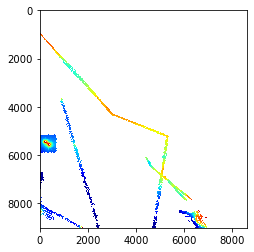

maxDepth. Values from -4533.2 to -11.2


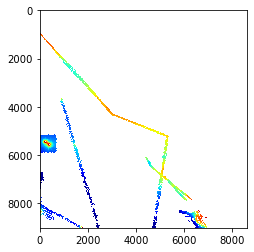

meanDepth. Values from -4579.0 to 120.49


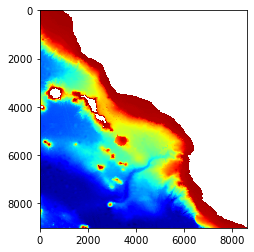

standardDeviation. Values from -1.0 to 246.9


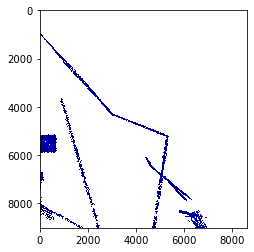

nbOfSounds. Values from 1.0 to 2745.0


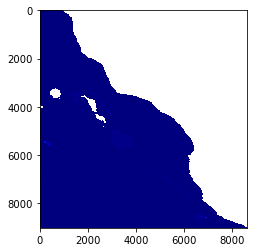

interpolatedCell. Values from 0.0 to 1.0


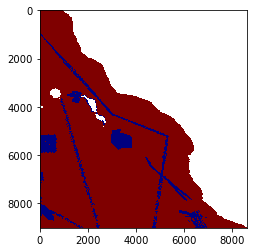

smoothedDepth. Values from -4576.3 to 211.41


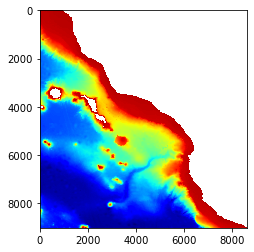

smoothedMeanDifference. Values from 0.0 to 580.52


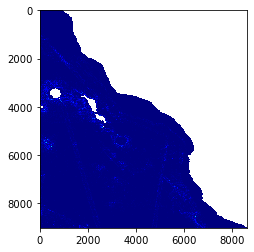

CPU times: user 11.5 s, sys: 17.2 s, total: 28.7 s
Wall time: 29.8 s


In [7]:
%%time
# Display resulting rasters
for column in emoFile.minmax.keys() :
    if column != 'latitude' and column != 'longitude' and emoFile.min(column) <= emoFile.max(column):
        print("{}. Values from {} to {}".format(column, emoFile.min(column), emoFile.max(column)))
        plt.imshow(raster[column], cmap='jet', vmin=emoFile.min(column), vmax=emoFile.max(column))
        plt.show()
    